v9 latent_dim = 20 -> 200, dropout_rate = 0.4 -> 0.3
****
v12 n_epochs = 20 -> 225
***
v15 remove layers, image_size 128 -> 64, trainable_params 6e+6 -> 2e+6, n_epochs = 200 -> 50
***
v17 add batch normalization
***
v18 change data load method because ImageDataGenerator is suspected of malfunctioning
***
change vae model

## Golab settings

In [8]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
!pip install kaggle

api_token = {"username":"dmitrysokolevskiy","key":"f4f96f70de8920f018ada21696cda204"}

import json
import zipfile
import os

!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

if not os.path.exists("/content/competitions/celeba-dataset"):
    os.makedirs("/content/competitions/celeba-dataset")

os.chdir('/content/competitions/celeba-dataset')

for file in os.listdir():
    if zipfile.is_zipfile(file):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.32G/1.33G [00:05<00:00, 273MB/s]
100% 1.33G/1.33G [00:06<00:00, 238MB/s]


## Import modules

In [9]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

## Configuration class

In [10]:
class Config:
    seed = 44
    n_epochs = 50
    batch_size = 32
    dropout_rate = 0.3
    latent_space_dim = 200
        
    validation_rate = 0.2
    
    image_size = 128
    channels = 3
    
    
    optimizer = 'adam'
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  mode='auto',
                                  factor=0.8,
                                  patience=2,
                                  epsilon=1e-4,
                                  coldown=5,
                                  min_lr=1e-5,
                                  verbose=1)
    
    checkpoint_best = ModelCheckpoint('best_model.h5',
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=False)
    
    checkpoint_last = ModelCheckpoint('last_model.h5',
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_best_only=False,
                                      save_weights_only=False)
  
    
    callbacks = [reduce_lr, checkpoint_best, checkpoint_last]
    
    paths = {'images_folder': '/content/competitions/celeba-dataset/img_align_celeba/img_align_celeba/',
             'list_attributes_file': '/content/competitions/celeba-dataset/list_attr_celeba.csv'}

In [11]:
config = Config()

## Data load

In [12]:
def build_decoder(test=False, out_size=(config.image_size, config.image_size)):
    def decoder(path):
        img = file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels=config.channels)  
        img = tf.image.resize(img, (config.image_size, config.image_size))
        img = tf.cast(img, tf.float32) / 255.0
        return img
    def decoder_train(path):
        return decoder(path), decoder(path)

    return decoder if test else decoder_train

In [13]:
def build_dataset(paths, test=False, shuffle=1, batch_size=1):
    AUTO = tf.data.experimental.AUTOTUNE
    decoder = build_decoder(test)

    dset = tf.data.Dataset.from_tensor_slices(paths)
    dset = dset.map(decoder, num_parallel_calls=AUTO)
    
    dset = dset.shuffle(shuffle)
    dset = dset.batch(batch_size)
    return dset

In [14]:
image_paths = glob.glob(config.paths['images_folder'] + '*.jpg')

train_paths, valid_paths, _, _ = train_test_split(image_paths, image_paths, test_size=config.validation_rate, shuffle=True)

train_dataset = build_dataset(train_paths, batch_size=config.batch_size)
valid_dataset = build_dataset(valid_paths, batch_size=config.batch_size)

<Figure size 288x288 with 0 Axes>

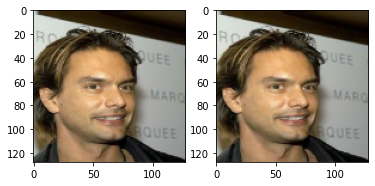

In [15]:
plt.figure(figsize=(4,4))
for n, (image, label) in enumerate(train_dataset.unbatch().take(1)):
    f, (ax1, ax2) = plt.subplots(1, 2) 
    
    ax1.imshow(image)
    ax2.imshow(label)
plt.show()


## Model architecture

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Lambda, UpSampling2D, Conv2DTranspose, Reshape

from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

In [17]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    
    epsilon = K.random_normal(shape=(batch, config.latent_space_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
def VAE(input_shape=(config.image_size, config.image_size, config.channels)):
    
    #Encoder
    input_encoder = Input(shape=(input_shape))
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_encoder)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)   
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)   
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)    
    x = Flatten()(x)

    latent_mu = Dense(config.latent_space_dim, name='latent_mean')(x)
    latent_log_var = Dense(config.latent_space_dim, name='latent_log_var')(x)
    latent_sample = Lambda(sampling)([latent_mu, latent_log_var])

    encoder = Model(input_encoder, [latent_mu, latent_log_var, latent_sample], name='encoder')

    latent_input = Input(shape=(config.latent_space_dim,), name='decoder_input')
    x = Dense(8 * 8 * config.image_size)(latent_input)
    x = Reshape((8, 8, config.image_size))(x)
    x = UpSampling2D((2, 2))(x)
    X = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(X)
    X = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    X = Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    X = Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    output_decoder = Conv2DTranspose(config.channels, (3, 3), activation='sigmoid', padding='same')(x)
    
    decoder = Model(latent_input, output_decoder, name='decoder')

    output_vae = decoder(encoder(input_encoder)[2])
    vae = Model(input_encoder, output_vae, name ='vae')
    
    
    reconstruction_loss = binary_crossentropy(input_encoder, output_vae) * (config.image_size * config.image_size)
    reconstruction_loss = K.mean(reconstruction_loss)

    kl_loss = 1 + latent_log_var - K.square(latent_mu) - K.exp(latent_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)  
    vae.add_metric(reconstruction_loss, name='reconstruction_loss')
    vae.add_metric(kl_loss, name='kl_divergence_loss')

    return vae, encoder, decoder

In [19]:
vae, encoder, decoder = VAE()
vae.compile(optimizer=config.optimizer)
    
vae.build(input_shape=(config.image_size, config.image_size, config.channels))
encoder.summary()
decoder.summary()
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

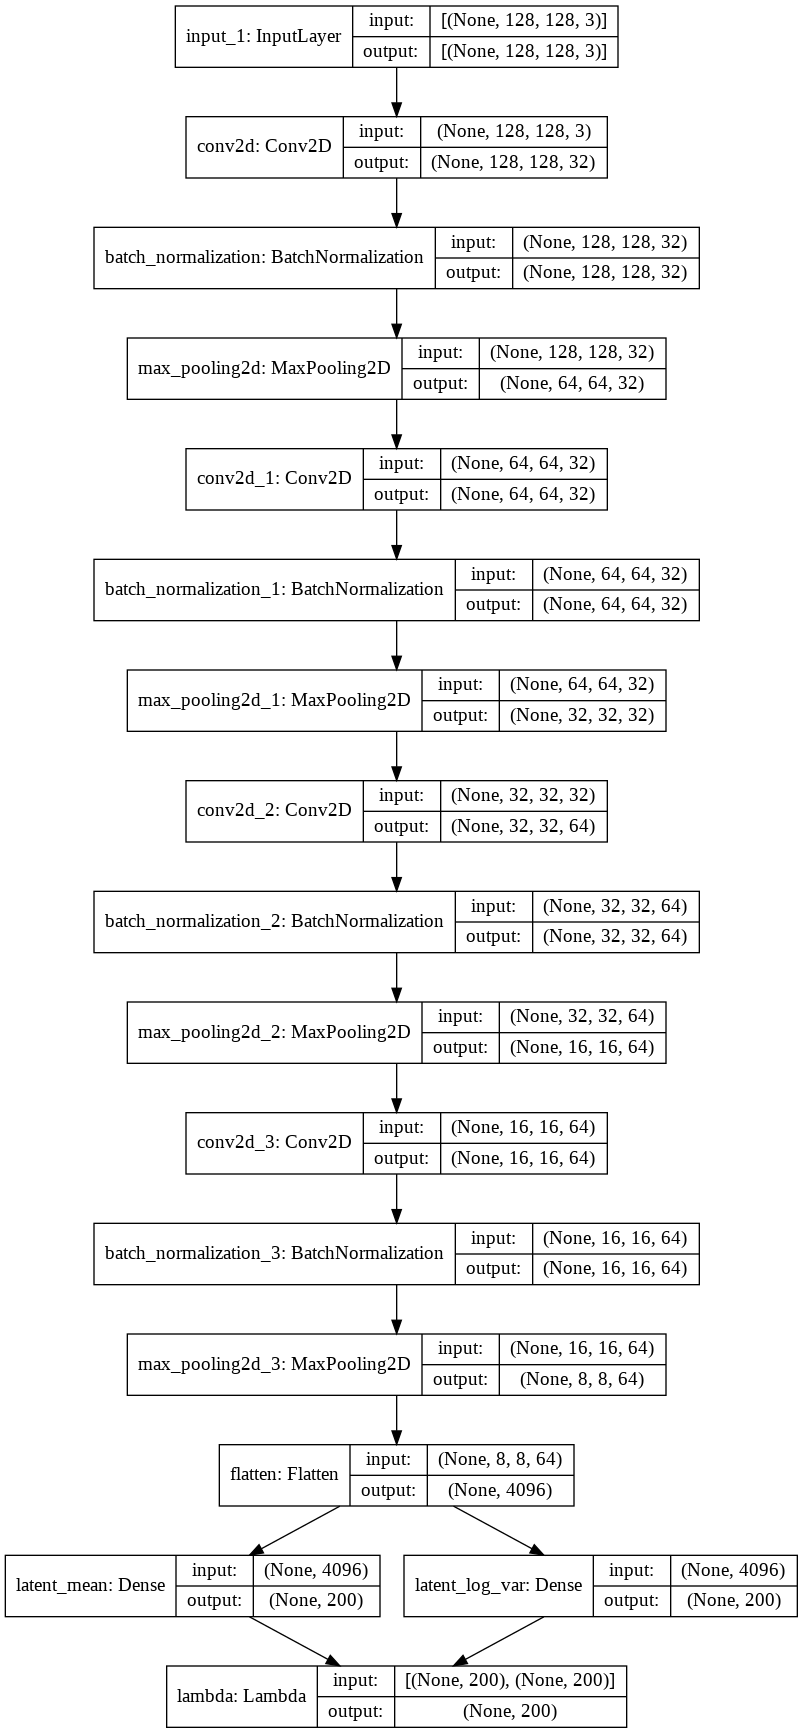

In [20]:
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)

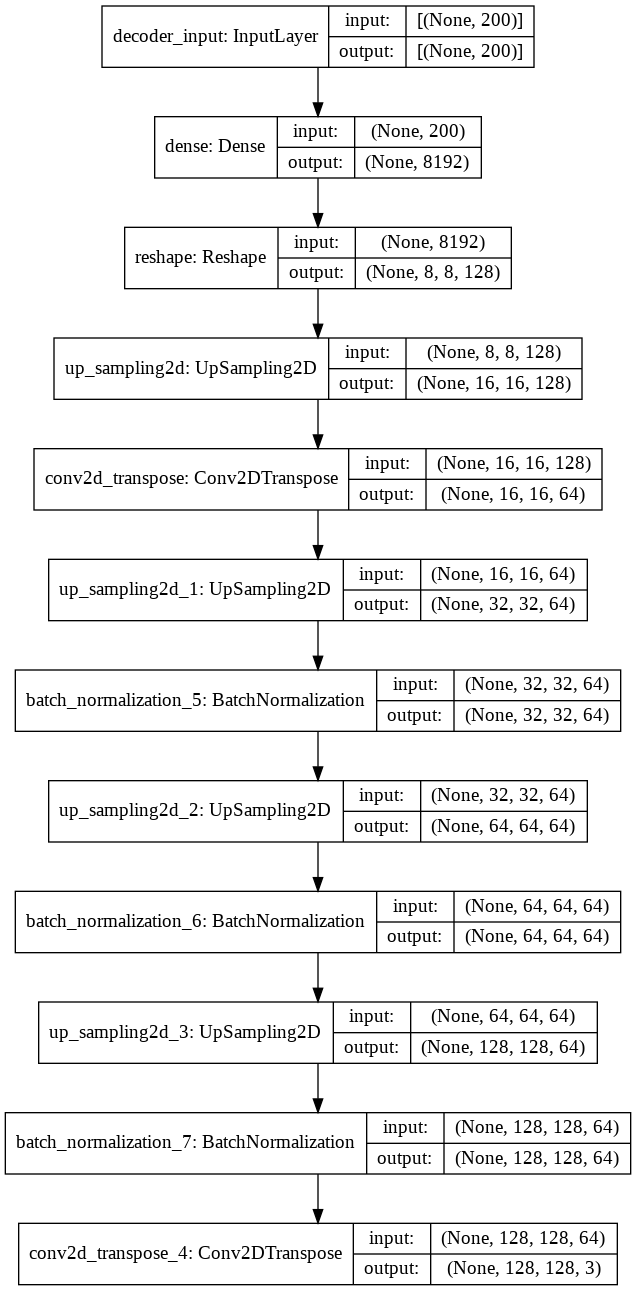

In [21]:
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)

In [22]:
if os.path.isfile("best_model.h5"):
    vae.load_weights('best_model.h5')

In [23]:
vae.fit(train_dataset,
        epochs=config.n_epochs,
        callbacks=config.callbacks,
        validation_data=valid_dataset)

Epoch 1/50
5065/5065 [==============================] - 393s 76ms/step - loss: 8812.9506 - reconstruction_loss: 8422.2695 - kl_divergence_loss: 161.6230 - val_loss: 8430.5176 - val_reconstruction_loss: 8285.6162 - val_kl_divergence_loss: 144.8995

Epoch 00001: val_loss improved from inf to 8430.51758, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoch 2/50
5065/5065 [==============================] - 380s 75ms/step - loss: 8441.2979 - reconstruction_loss: 8284.6621 - kl_divergence_loss: 142.6008 - val_loss: 8392.2695 - val_reconstruction_loss: 8249.2578 - val_kl_divergence_loss: 143.0074

Epoch 00002: val_loss improved from 8430.51758 to 8392.26953, saving model to best_model.h5

Epoch 00002: saving model to last_model.h5
Epoch 3/50
5065/5065 [==============================] - 384s 76ms/step - loss: 8407.4938 - reconstruction_loss: 8255.3398 - kl_divergence_loss: 143.8667 - val_loss: 8374.1494 - val_reconstruction_loss: 8232.5225 - val_kl_divergence_loss: 1

In [24]:
vae.load_weights('./best_model.h5')

## Reconstruction result

In [25]:
test_dataset = build_dataset(valid_paths, test=True)

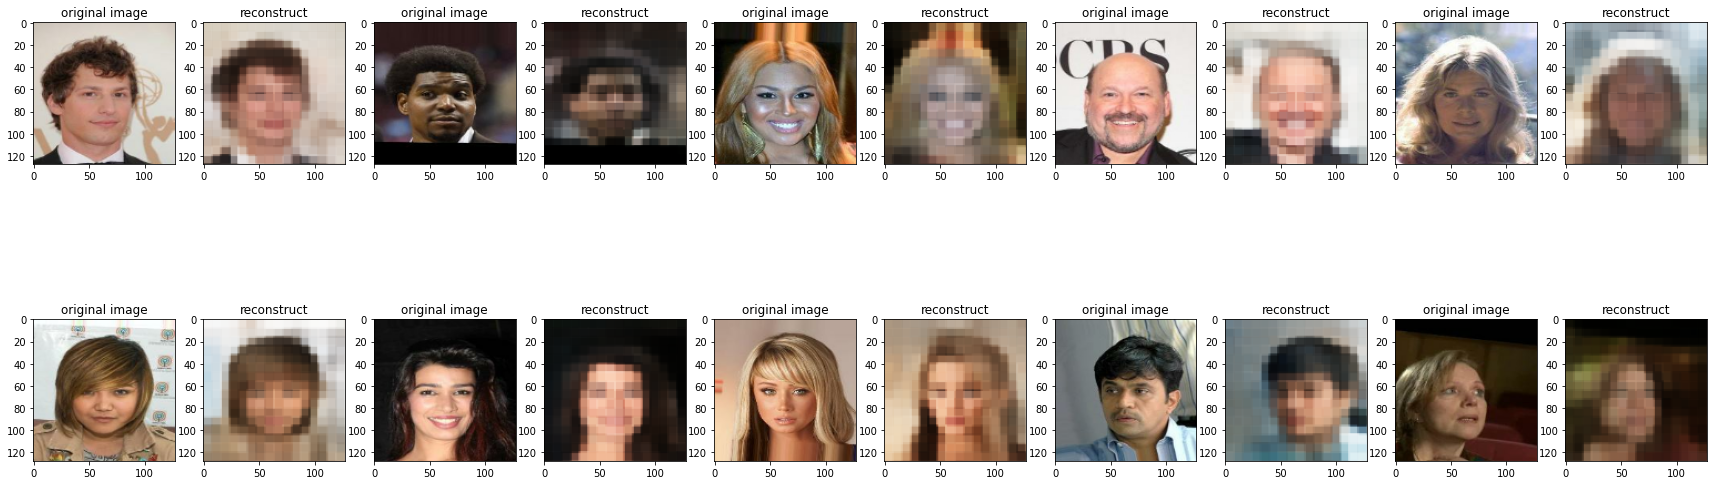

In [32]:
data = list(test_dataset.take(20))

fig = plt.figure(figsize=(30, 10))
for n in range(0, 20, 2):
    image = vae.predict(data[n])
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(np.squeeze(data[n]))
    plt.title('original image')
    
    plt.subplot(2, 10, n + 2)
    plt.imshow(np.squeeze(image))
    plt.title('reconstruct')
    
plt.show()

## Generation new faces

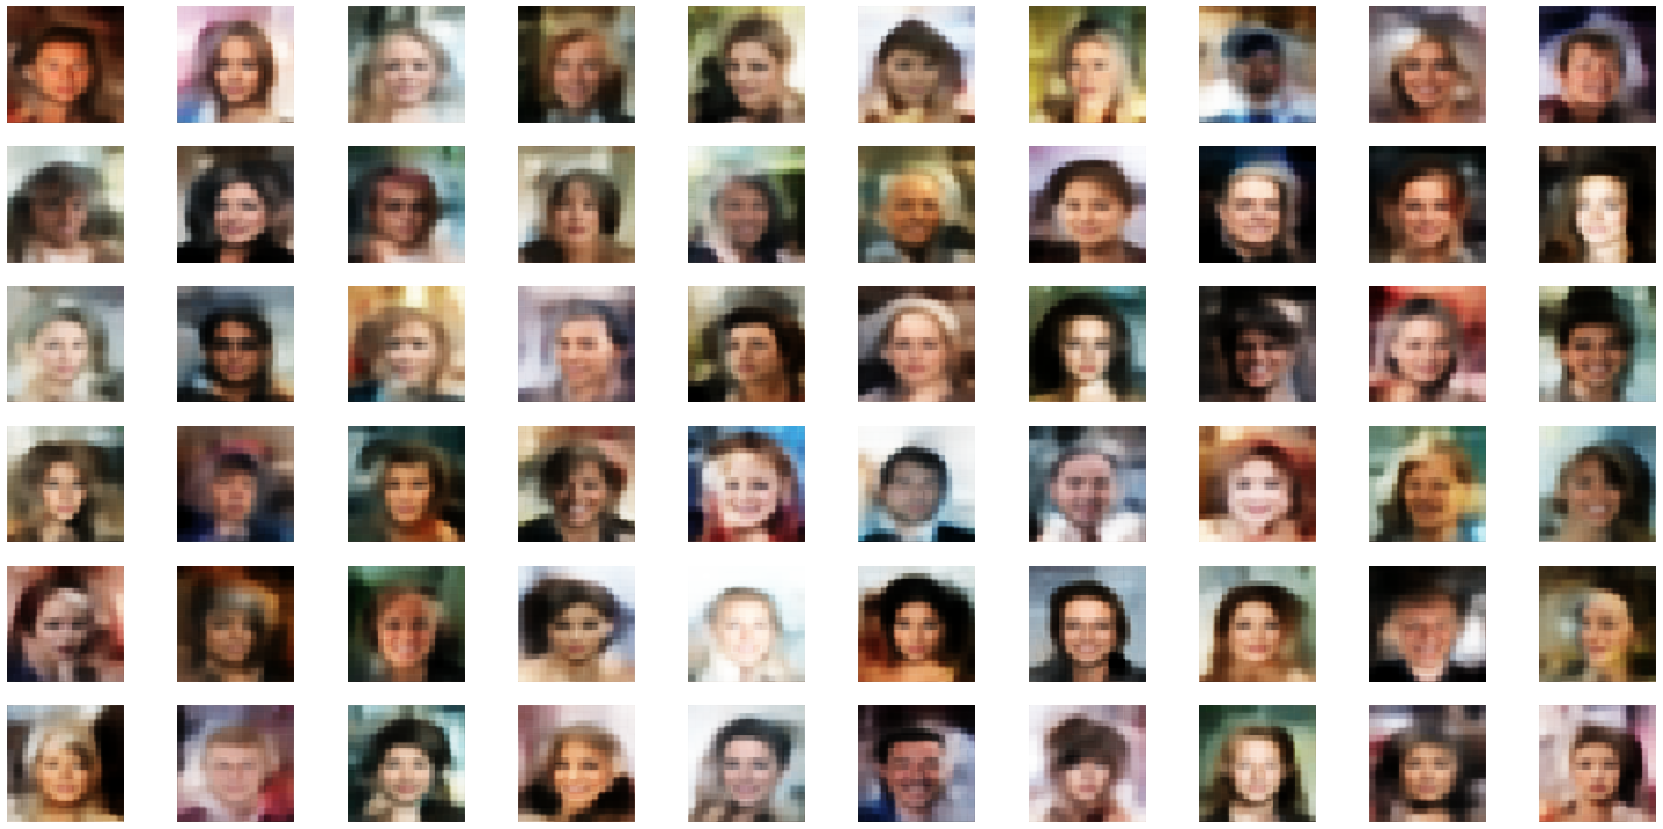

In [27]:
n_show_new_images = 60
random_codes = np.random.normal(size=(n_show_new_images, config.latent_space_dim))
new_faces = decoder.predict(np.array(random_codes))

fig = plt.figure(figsize=(30, 15))

for i in range(n_show_new_images):
    ax = fig.add_subplot(6, 10, i+1)
    ax.imshow(new_faces[i])
    ax.axis('off')
plt.show()

## Show latent space distribution

In [30]:
z_test = encoder.predict(test_dataset, verbose = 1)

40520/40520 [==============================] - 82s 2ms/step


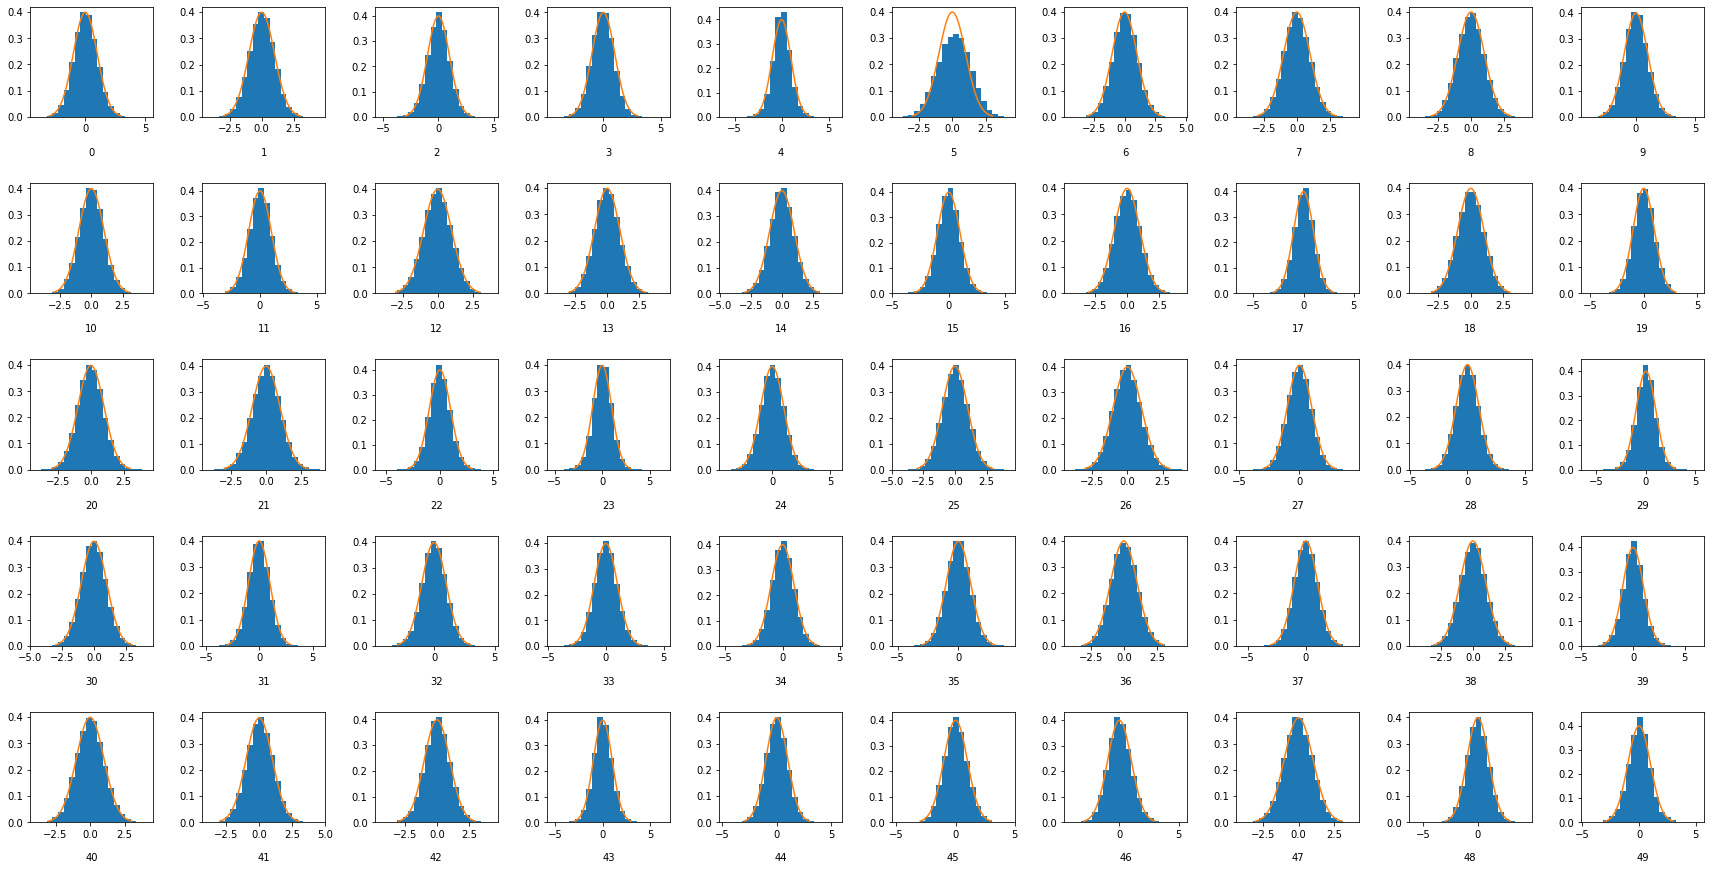

In [31]:
from scipy.stats import norm

z_test_samples = z_test[2]
x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(30, 15))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test_samples[:, i], density=True, bins = 20)

    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x, norm.pdf(x))

plt.show()